In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
import scipy.stats as st
import numpy as np
from math import sqrt

## Описание набора данных
Этот набор данных содержит результаты A/B тестирования для Cookie Cats, в ходе которого изучалось влияние переноса начальных ворот в игре с 30-го на 40-й уровень. После установки игры игроки были случайным образом распределены по gate_30 или gate_40.  У нас есть данные о 90 189 игроках, которые установили игру во время выполнения AB-теста. 
Переменные: 
1. userid: Уникальный номер, который идентифицирует каждого игрока. 
2. version: Был ли игрок включен в контрольную группу (gate_30 - ворота на 30-м уровне) или в группу с перемещенными воротами (gate_40 - ворота на 40-м уровне). 
4. sum_gamerounds: количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки. 
5. retention_1: Вернулся ли игрок и сыграл ли он через 1 день после установки? 
6. retention_7: Вернулся ли плеер и играл ли он через 7 дней после установки?

# Проверяем гипотезу
Перемещение ворот с 30-го на 40-й уровень увеличит игровую вовлеченность и retention (удержание) игроков, так как у них останется более положительное первое впечатление об игре.

In [2]:
### Загружаем данные из файла
df = pd.read_csv('D:/Учёба/Data/cookie_cats/cookie_cats.csv', sep=',')

### 1. Разведочный аналих данных.
Выведем количество строк и столбцов, типы данных в каждом столбце, проверим наличие пропущенных значений.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
### Проверяем, что все наши userid уникальные
df['userid'].nunique()

90189

In [5]:
### Смотрим статистику по количеству сыграных раундов.
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [6]:
df['sum_gamerounds'].median()

16.0

#### Первые выводы
- У нас есть в данных пользователи, которые не сыграли ни одного раунда. 
- Есть пользователь, который сыграл 49854 раунда, а так же другие пользователи, которые сыграли аномально большое количество раундов, что может быть ошибкой или выбросом.
- Среднее количество сыгранных раундов 51.8. Однако видно, 75% всех пользователей сыграли меньше 51 раунда.
- Медианное значение 16 раундов. Оно сопадает с данными о том, что половина всех игроков сыграла до 16 раундов включительно.


#### Проведём разбивку на контрольную и тестовую группу

In [7]:
df_gate30 = df[df['version']=='gate_30']
df_gate40 = df[df['version']=='gate_40']

In [8]:
### сравним медианные значения количества сыгранных раундов в группах
print(df_gate30['sum_gamerounds'].median())
print(df_gate40['sum_gamerounds'].median())

17.0
16.0


#### Сравним основные статистические данные по группа

In [9]:
df_gate30['sum_gamerounds'].describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [10]:
df_gate40['sum_gamerounds'].describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64

#### Выводы по основной статистике по группа
Показатели в целом находятся на одинаковых уровных. Есть значительное разичие в максимальном количестве сыгранных раундов.

### 2. Визуализируем распределение количества игровых раундов и ретеншена по группам

C:\Users\gondy\AppData\Local\Temp\ipykernel_5820\1276070303.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gate_30_data, gate_40_data],


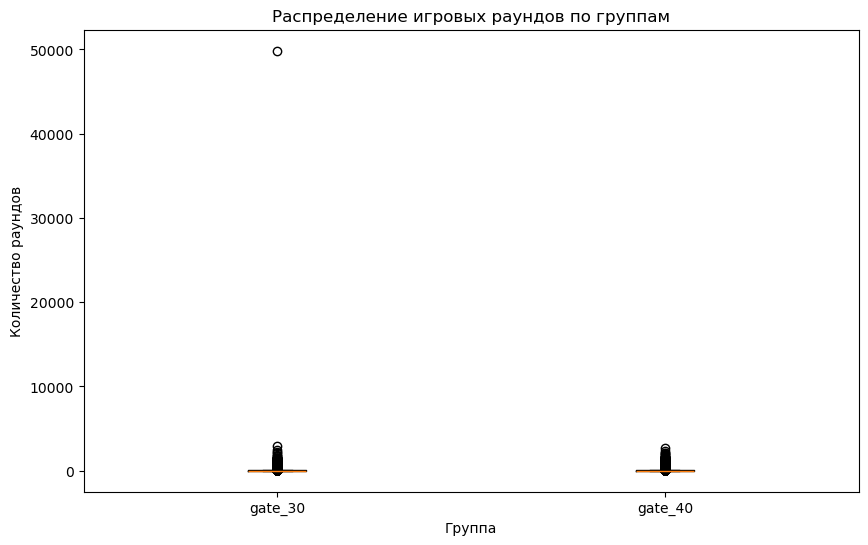

In [11]:
gate_30_data = df_gate30['sum_gamerounds']
gate_40_data = df_gate40['sum_gamerounds']

plt.figure(figsize=(10, 6))
plt.boxplot([gate_30_data, gate_40_data], 
            labels=['gate_30', 'gate_40'])
plt.title('Распределение игровых раундов по группам')
plt.ylabel('Количество раундов')
plt.xlabel('Группа')
plt.show()

Видим выброс в контрольной группе, в которой и был игрок количеством сыгранных раундов 49854. Основная часть игроков в обеих группах сыграла в промежутке от 0 до приблизительно 3000

#### Просчитаем и визуализируем средние значения по retention для обеих групп

In [12]:
### расчитаем средние для каждого ретеншена и группы
for i in df['version'].unique():
    print(f'\nДанные о среднем для группы {i}')
    r1 = df[df['version']==i]['retention_1'].mean()*100
    r2 = df[df['version']==i]['retention_7'].mean()*100
    print(f'Среднее значение для ретеншена 1-го дня равен {r1:.2f}%')
    print(f'Среднее значение для ретеншена 7 дней равен {r2:.2f}%')


Данные о среднем для группы gate_30
Среднее значение для ретеншена 1-го дня равен 44.82%
Среднее значение для ретеншена 7 дней равен 19.02%

Данные о среднем для группы gate_40
Среднее значение для ретеншена 1-го дня равен 44.23%
Среднее значение для ретеншена 7 дней равен 18.20%


<Figure size 1000x600 with 0 Axes>

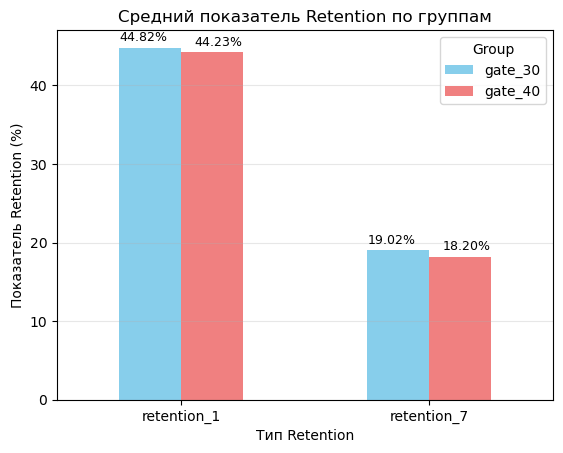

In [13]:
# Создаем сводную таблицу
retention_pivot = df.groupby('version')[['retention_1', 'retention_7']].mean().T
retention_pivot = retention_pivot * 100  # Convert to percentage

# Визуализация
plt.figure(figsize=(10, 6))
retention_pivot.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Средний показатель Retention по группам')
plt.ylabel('Показатель Retention (%)')
plt.xlabel('Тип Retention')
plt.xticks(rotation=0)
plt.legend(title='Group')
plt.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, (idx, row) in enumerate(retention_pivot.iterrows()):
    for j, version in enumerate(['gate_30', 'gate_40']):
        plt.text(i + j*0.3 - 0.15, row[version] + 0.5, f'{row[version]:.2f}%', 
                ha='center', va='bottom', fontsize=9)

plt.show()

#### Выводы по retention по группам
В обоих случайх показатели retention у тестовой группы немного ниже показателей в контрольной группе 

### 3. Проверка гипотезы статистическими методами.
##### Гипотеза звучит:
Перемещение ворот с 30-го на 40-й уровень увеличит игровую вовлеченность и retention (удержание) игроков, так как у них останется более положительное первое впечатление об игре.

In [14]:
### Сначала используя критерий Манна-Уитни для проверки различий в данных между выборками по количеству сыгранных раундов.
s, p = st.mannwhitneyu(gate_30_data, gate_40_data)
if p >= 0.05:
    print(f'pvalue равный {p:.3f} указывает нам на то, что данные выборки не отличаются друг от друга')
    print('Соотвественно получается, что изменение положения раунда с ожиданием не увеличило игровую вовлечённость')
else:
    print(f'pvalue равный {p:.3f} указывает нам на то, что данные выборки отличаются друг от друга')
    print('Изменение раунда с ожиданием повлияло на игровую вовлечённость')

pvalue равный 0.050 указывает нам на то, что данные выборки не отличаются друг от друга
Соотвественно получается, что изменение положения раунда с ожиданием не увеличило игровую вовлечённость


#### Проверим гипотезу на данных о Retention для 1 и 7 дней
Будем использовать для этого двувуборочный z-критерий.

In [15]:
### Для расчётов критерия нам нужны данные: среднее, стандартное отклонение и количество наблюдений
### Расчёты данных для Retention_1
avg_30 = df_gate30['retention_1'].mean()
avg_40 = df_gate40['retention_1'].mean()

cnt_30 = df_gate30['userid'].count()
cnt_40 = df_gate40['userid'].count()
### Расчёты данных для Retention_7
avg7_30 = df_gate30['retention_7'].mean()
avg7_40 = df_gate40['retention_7'].mean()

In [21]:
### Прописываем формулу для рассчёта z-критерия
def two_proportions_z_test(avg1, cnt1, avg2, cnt2):
    p = (avg1 * cnt1 + avg2 * cnt2) / (cnt1 + cnt2)
    se = sqrt(p * (1 - p) * ( 1/cnt1 + 1/cnt2))
    z = (avg1 - avg2) / se
    p_value = 2 * (1 - st.norm.cdf(abs(z)))
    return z, p_value

In [27]:
### Рассчитывае z-критерий для retention_1
z, p = two_proportions_z_test(avg_30, cnt_30, avg_40, cnt_40)
print("Результаты Z-теста:")
print(f"Z-статистика: {z:.4f}")
print(f"P-value: {p:.6f}")


# Проверка статистической значимости
alpha = 0.05
if p < alpha:
    print(f"✓ Разница статистически значима (p < {alpha})")
else:
    print(f"✗ Разница не статистически значима (p ≥ {alpha})")


Результаты Z-теста:
Z-статистика: 1.7841
P-value: 0.074410
✗ Разница не статистически значима (p ≥ 0.05)


In [28]:
### Рассчитывае z-критерий для retention_7
z, p = two_proportions_z_test(avg7_30, cnt_30, avg7_40, cnt_40)
print("Результаты Z-теста:")
print(f"Z-статистика: {z:.4f}")
print(f"P-value: {p:.6f}")

# Проверка статистической значимости
alpha = 0.05
if p < alpha:
    print(f"✓ Разница статистически значима (p < {alpha})")
else:
    print(f"✗ Разница не статистически значима (p ≥ {alpha})")


Результаты Z-теста:
Z-статистика: 3.1644
P-value: 0.001554
✓ Разница статистически значима (p < 0.05)


#### Выводы по результатам данных по статистическим критериям
Перемещение уровня на 40 уровень не повлияло на вовлечённость игроков по количеству сыгранным пользователями раундов.
Однако наблюдается значимая разница между вовлечённость игроков для 7-дневного периода. По результатам тестовая группа показала результат хуже, чем в контрольной группе.


## Общий вывод по анализу результатов АБ тестирования
Перемещение уровня не привело к повышениею вовлечённости и удержанию пользователей в игре Cookie Cats.
При наблюдении удержания пользователя в игре 7 дней тестовая группа показала результаты хуже, чем контрольная. Более высокий процент удержания пользователей в игре в недельный период значимый показатель. Так эти дополнительные пользователи смогу привлечь больше новых игроков.
Следовательно, вводить это изменение на данный момент нецелесообразно.